# Data download

In [ ]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


In [ ]:
import copernicusmarine
import os

In [ ]:
copernicusmarine.get(
    dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D",
    output_directory="/scratch/chsu/CMEMS/",
    username=os.getenv("COPERNICUSMARINE_SERVICE_USERNAME"),
    password=os.getenv("COPERNICUSMARINE_SERVICE_PASSWORD")
)

In [ ]:
copernicusmarine.get(
    dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D",
    output_directory="/scratch/chsu/CMEMS/",
    username=os.getenv("COPERNICUSMARINE_SERVICE_USERNAME"),
    password=os.getenv("COPERNICUSMARINE_SERVICE_PASSWORD")
)

# Map binning test

In [14]:
data_dirs = [
    '/scratch/chsu/CMEMS/SEALEVEL_GLO_PHY_L4_NRT_008_046/cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D_202311/2024/07',
    '/scratch/chsu/CMEMS/SEALEVEL_GLO_PHY_L4_NRT_008_046/cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D_202506/2024/07'
]
data_names = [
    'nrt_global_allsat_phy_l4_20240701_20240707.nc',
    'nrt_global_allsat_phy_l4_20240701_20250501.nc'
]


In [ ]:
import xarray as xr
ds_low = xr.open_dataset(os.path.join(data_dirs[0],data_names[0]))
ds_high = xr.open_dataset(os.path.join(data_dirs[1],data_names[1]))

In [16]:
from map_binning.binning import Binning
class_bin = Binning(
     ds_high=ds_high, ds_low=ds_low, var_name='sla', xdim_name='longitude', ydim_name='latitude'
)
da = class_bin.mean_binning(
    precomputed_binning_index=False,
    pickle_filename="cmems_nrt_coastal_bin.pkl",
    pickle_location="../pickle_folder"
)

/home/chsu/map-binning-project/map_binning/binning.py:177: RuntimeWarning: Mean of empty slice
  output[:, i, j] = np.nanmean(values, axis=1)


In [17]:
da1 = class_bin.mean_binning(
    precomputed_binning_index=True,
    pickle_filename="cmems_nrt_coastal_bin.pkl",
    pickle_location="../pickle_folder"
)

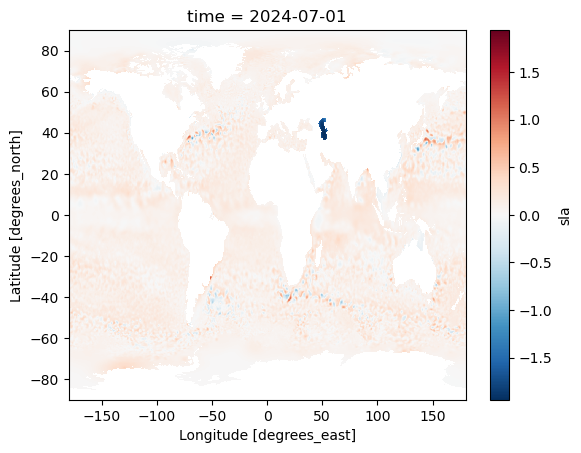

In [18]:
da.plot()

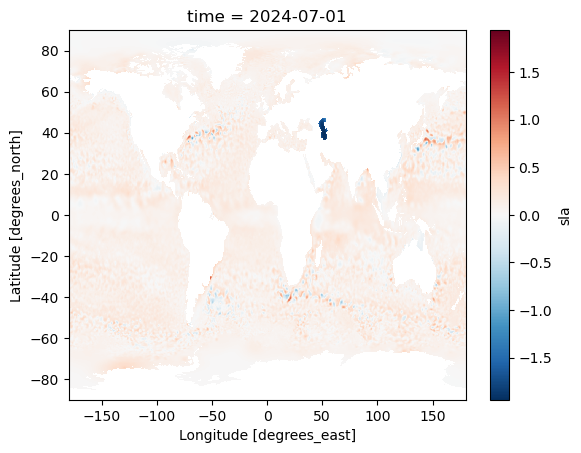

In [19]:
da1.plot()

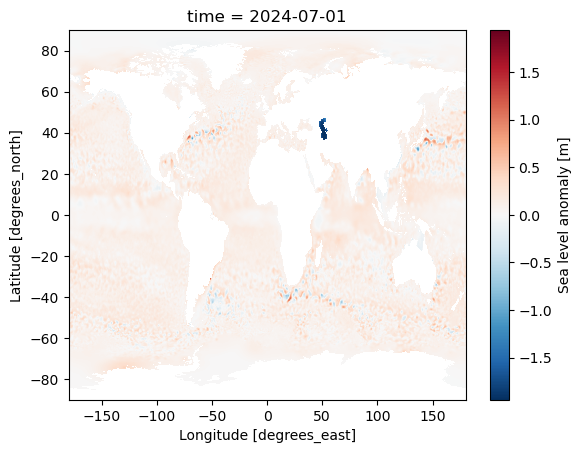

In [20]:
ds_high.sla.plot()

# original code testing

In [5]:
import numpy as np
from scipy.spatial import cKDTree
import xarray as xr

def create_binning_index(ds_high, ds_low, search_radius=None):
    """
    Create a mapping dictionary where each low-res point maps to 
    indices of high-res points within a certain radius.
    
    Parameters:
    ds_high: high resolution dataset
    ds_low: low resolution dataset  
    search_radius: radius in degrees to search for points (if None, auto-calculate)
    
    Returns:
    dict: {(lat_idx, lon_idx): [list of high-res indices]}
    """
    
    # Get coordinate arrays
    high_lats = ds_high.latitude.values
    high_lons = ds_high.longitude.values
    low_lats = ds_low.latitude.values
    low_lons = ds_low.longitude.values
    
    # Create meshgrids for high-res points
    high_lon_grid, high_lat_grid = np.meshgrid(high_lons, high_lats)
    high_points = np.column_stack([high_lat_grid.ravel(), high_lon_grid.ravel()])
    
    # Build KDTree for fast spatial queries
    tree = cKDTree(high_points)
    
    # Auto-calculate search radius if not provided
    if search_radius is None:
        # Use half the distance between low-res points as radius
        lat_spacing = np.abs(np.diff(low_lats)).mean()
        lon_spacing = np.abs(np.diff(low_lons)).mean()
        search_radius = max(lat_spacing, lon_spacing) * 0.6
    
    binning_index = {}
    
    # For each low-res point, find nearby high-res points
    for i, lat in enumerate(low_lats):
        for j, lon in enumerate(low_lons):
            # Find all high-res points within radius
            indices = tree.query_ball_point([lat, lon], search_radius)
            
            if indices:  # Only store if there are points to bin
                # Convert 1D indices back to 2D indices for high-res grid
                lat_indices = np.array(indices) // len(high_lons)
                lon_indices = np.array(indices) % len(high_lons)
                binning_index[(i, j)] = list(zip(lat_indices, lon_indices))
    
    return binning_index

In [7]:
def apply_binning_with_index(ds_high, ds_low, binning_index, var_name):
    """
    Apply the precomputed binning index to aggregate high-res data.
    
    Parameters:
    ds_high: high resolution dataset
    ds_low: low resolution dataset (used for output structure)
    binning_index: precomputed mapping dictionary
    var_name: variable name to process (e.g., 'adt', 'sla', etc.)
    
    Returns:
    xr.DataArray: binned data on low-res grid
    """
    
    # Initialize output array
    output_shape = (len(ds_low.latitude), len(ds_low.longitude))
    if 'time' in ds_high.dims:
        output_shape = (len(ds_high.time),) + output_shape
        output = np.full(output_shape, np.nan)
    else:
        output = np.full(output_shape, np.nan)
    
    high_data = ds_high[var_name].values
    
    # Apply binning for each low-res point
    for (i, j), high_indices in binning_index.items():
        if high_indices:
            # Extract values from high-res points
            lat_idx, lon_idx = zip(*high_indices)
            
            if 'time' in ds_high.dims:
                # Handle time dimension
                values = high_data[:, lat_idx, lon_idx]
                # Calculate mean across spatial dimensions, preserving time
                output[:, i, j] = np.nanmean(values, axis=1)
            else:
                values = high_data[lat_idx, lon_idx]
                output[i, j] = np.nanmean(values)
    
    # Create output DataArray with proper coordinates
    if 'time' in ds_high.dims:
        coords = {
            'time': ds_high.time,
            'latitude': ds_low.latitude, 
            'longitude': ds_low.longitude
        }
        dims = ['time', 'latitude', 'longitude']
    else:
        coords = {
            'latitude': ds_low.latitude,
            'longitude': ds_low.longitude  
        }
        dims = ['latitude', 'longitude']
    
    return xr.DataArray(output, coords=coords, dims=dims, name=var_name)



In [14]:
# Usage example:
# Create the binning index once
print("Creating binning index...")
binning_index = create_binning_index(ds_high, ds_low)
print(f"Created index for {len(binning_index)} low-res points")

Creating binning index...
Created index for 1036800 low-res points


In [15]:
# Apply to your datasets (repeat for all 20 high-res maps)
var_name = 'sla'  # or whatever variable you're processing
da = apply_binning_with_index(ds_high, ds_low, binning_index, var_name)

/tmp/ipykernel_2506698/2422502061.py:35: RuntimeWarning: Mean of empty slice
  output[:, i, j] = np.nanmean(values, axis=1)


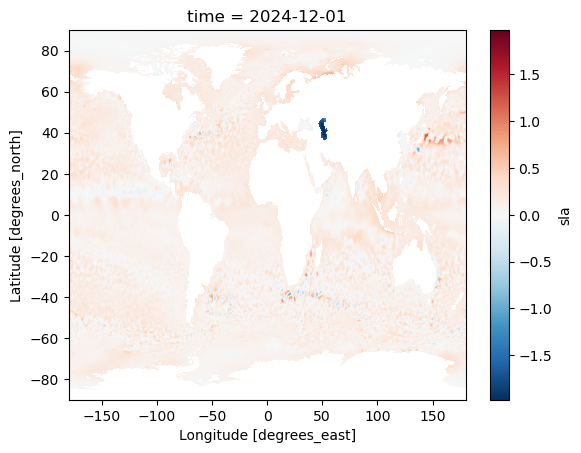

In [16]:
da.plot()

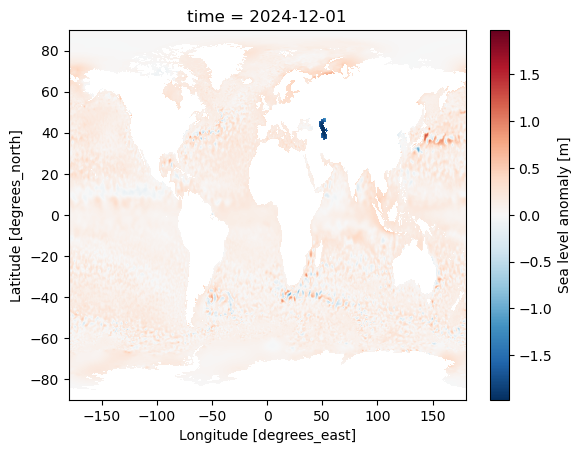

In [11]:
ds_high['sla'].plot()

In [12]:
da

<xarray.DataArray 'sla' (time: 1, latitude: 720, longitude: 1440)> Size: 8MB
array([[[    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        [    nan,     nan,     nan, ...,     nan,     nan,     nan],
        ...,
        [0.00035, 0.00035, 0.00035, ..., 0.00035, 0.00035, 0.00035],
        [0.00025, 0.00025, 0.00025, ..., 0.00025, 0.00025, 0.00025],
        [0.00015, 0.00015, 0.00015, ..., 0.00015, 0.00015, 0.00015]]])
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-12-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9

In [13]:
ds_low

<xarray.Dataset> Size: 83MB
Dimensions:    (time: 1, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-01-02
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv         (nv) int32 8B 0 1
Data variables: (12/13)
    crs        int32 4B ...
    lat_bnds   (latitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds   (longitude, nv) float32 12kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_sla    (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ...         ...
    vgosa      (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    err_vgosa  (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    flag_ice   (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Near-Real-Time Level-4 sea ...
    time_coverage_duration:          P1D
    time_coverage_end:               2024-01-02T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-01-01T12:00:00Z
    title:                           NRT merged all satellites Global Ocean G...